In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("data/target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")
df

,Standardized_SMILES,pchembl_value
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05
...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

def calculate_molwt(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None

def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol)
    return None
def calculate_QED(smiles):
    mol=Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.QED.default(mol)
    return

df['MolWt'] =df['Standardized_SMILES'].apply(calculate_molwt)
df['LogP'] = df['Standardized_SMILES'].apply(calculate_logp)
df['QED'] = df['Standardized_SMILES'].apply(calculate_QED)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Int64Index([1252, 1248, 60, 1044, 618, 619, 617, 611, 421, 286], dtype='int64')

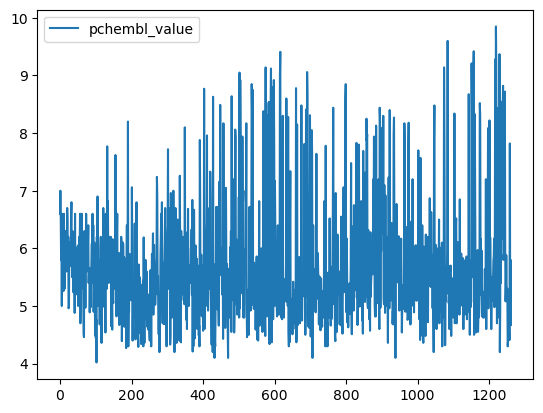

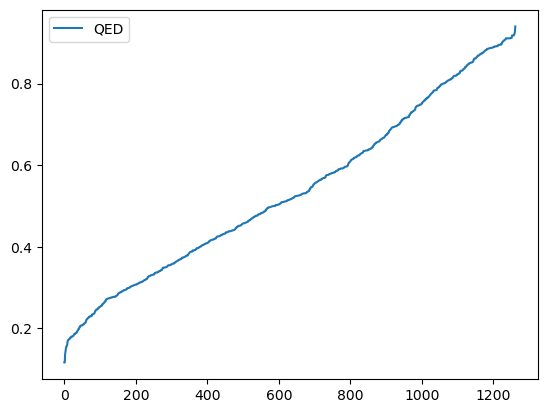

In [46]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df=df_copy
df.nlargest(10, ['QED']).index

subset

In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [10]:
smiles = df['Standardized_SMILES'].values

In [11]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [13]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
734,Cc1ccc2c(-c3nnc(SCCCN4CCc5ccc6oc(C(F)(F)C(F)(F...,6.60,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
717,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(F)(F)C(F)(F)...,7.00,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
217,CCc1nc2cc3c(c(Br)c2o1)CCN(CCCCSc1nnc(-c2cccc4n...,5.80,605.606,6.77792,0.142700,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
618,COc1ccccc1CC(c1ccccc1)N1CCNCC1,4.41,296.414,2.88420,0.917990,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1044,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2CCCCC2)c1,7.82,328.456,3.49240,0.920243,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)C1CCNC1,4.70,315.244,3.45350,0.922780,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1248,Oc1cccc(OC2CC3CCC(C2)N3Cc2ccccc2)c1,5.80,309.409,3.96660,0.927450,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
#Now incorporate this sort of noise into df during the training

In [15]:
X.shape

(1262, 20488)

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.3756321305028866, pvalue=1.4625670936090712e-05)
PearsonRResult(statistic=0.5178127109315322, pvalue=5.322701269663545e-10)
PearsonRResult(statistic=0.520912977072264, pvalue=4.026591785726903e-10)
PearsonRResult(statistic=0.7390265212676099, pvalue=5.1384763176627716e-23)
PearsonRResult(statistic=0.8696621339706352, pvalue=7.899346768889813e-40)
PearsonRResult(statistic=0.3944386580663086, pvalue=4.874097546915095e-06)
PearsonRResult(statistic=0.8017273294207561, pvalue=1.7039263069374767e-29)
PearsonRResult(statistic=0.5241272757214458, pvalue=3.006009617679745e-10)
PearsonRResult(statistic=0.7971370275635393, pvalue=2.1868800745593356e-29)


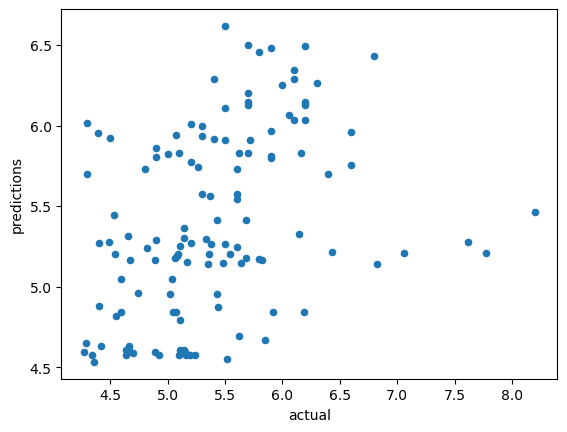

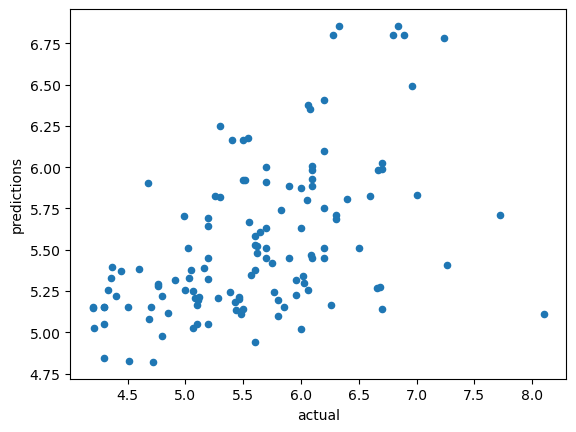

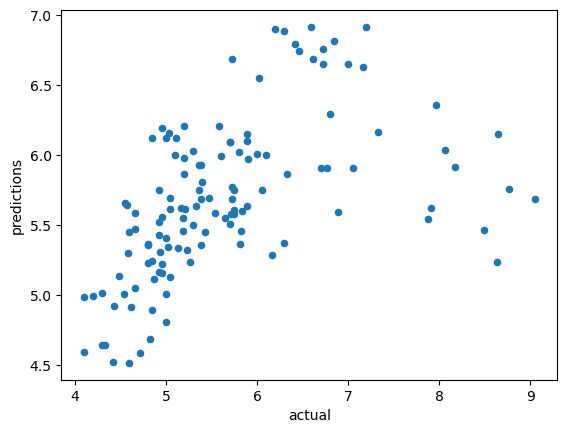

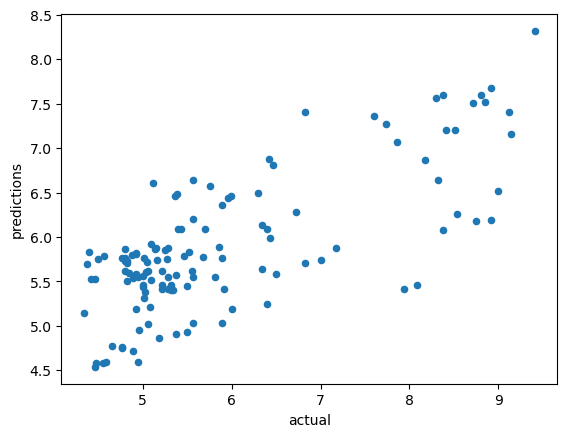

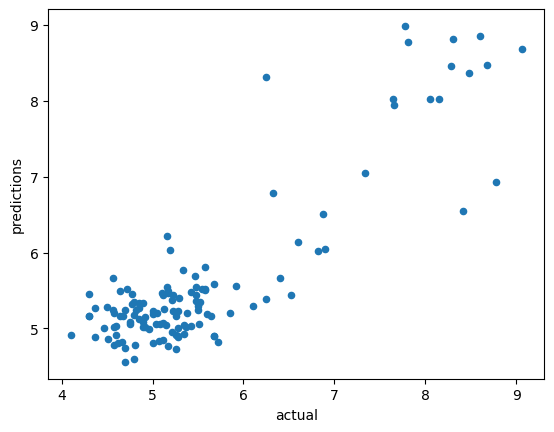

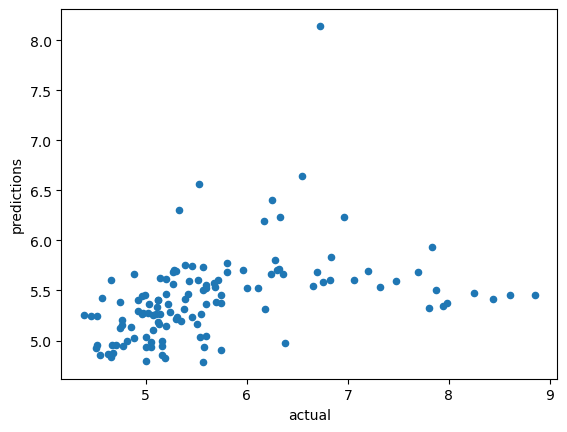

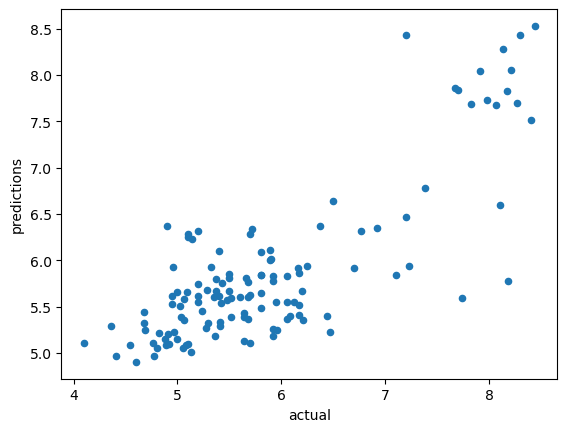

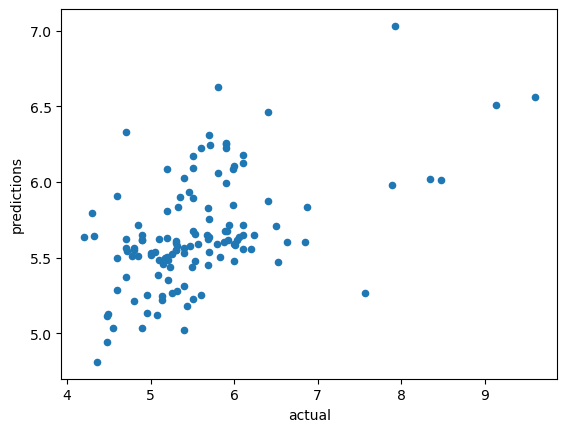

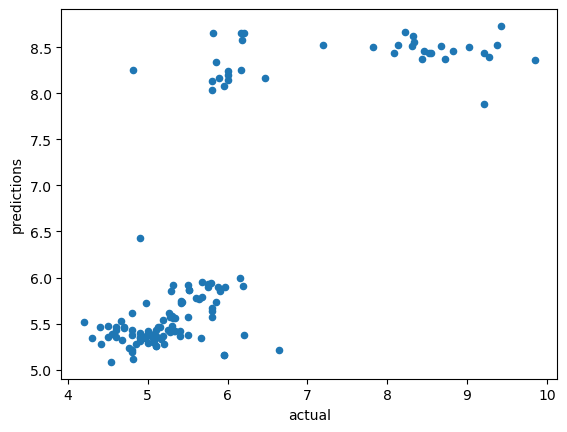

In [29]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [30]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(33, 3)
(18, 3)
(22, 3)
(14, 3)
(36, 3)
(26, 3)
(15, 3)
(8, 3)
(3, 3)


In [31]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(15, 3)
(12, 3)
(0, 3)
(5, 3)
(18, 3)
(8, 3)
(4, 3)
(2, 3)
(2, 3)


In [32]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(21, 3)
(20, 3)
(30, 3)
(37, 3)
(26, 3)
(23, 3)
(20, 3)
(31, 3)
(45, 3)


In [33]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(54, 3)
(71, 3)
(71, 3)
(70, 3)
(46, 3)
(66, 3)
(83, 3)
(81, 3)
(77, 3)


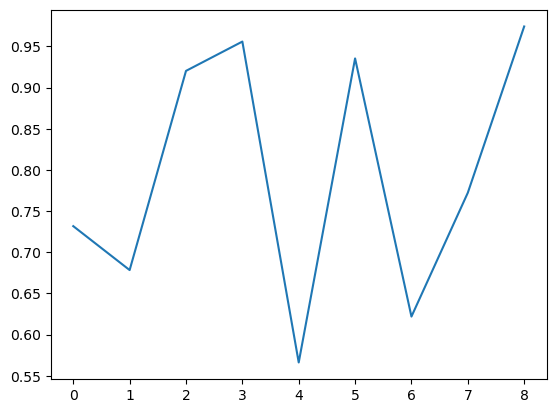

In [34]:
plt.plot(rmse)
plt.show()

In [35]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

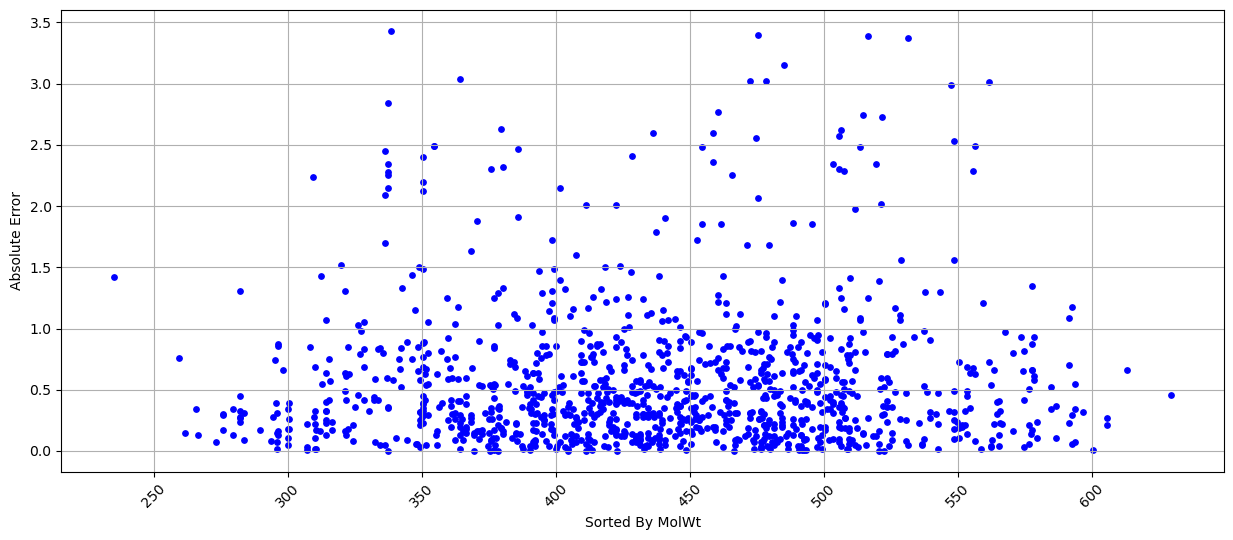

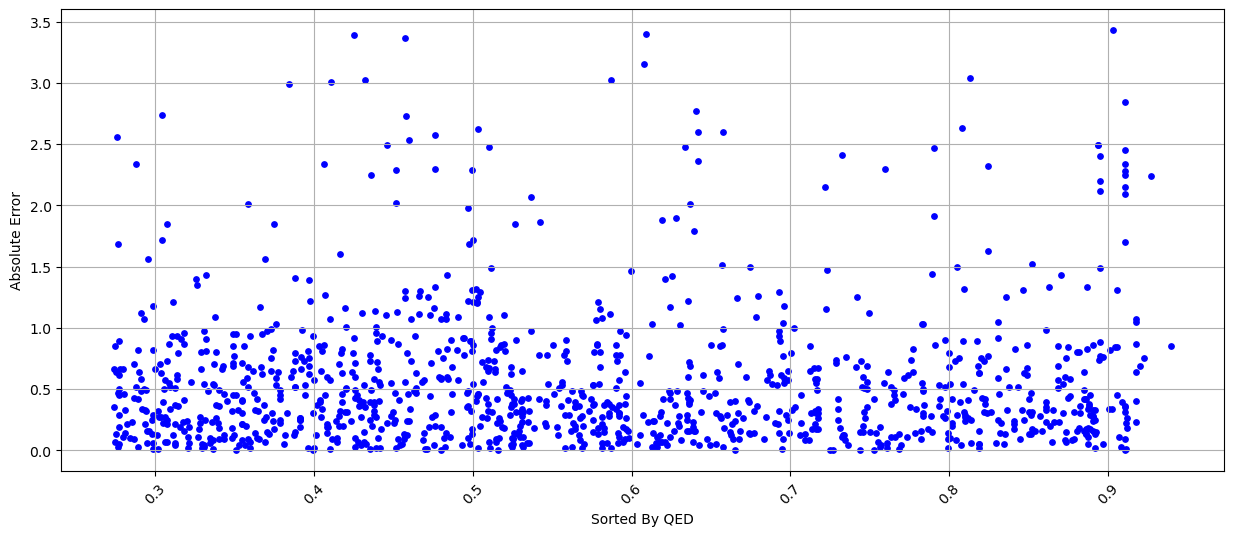

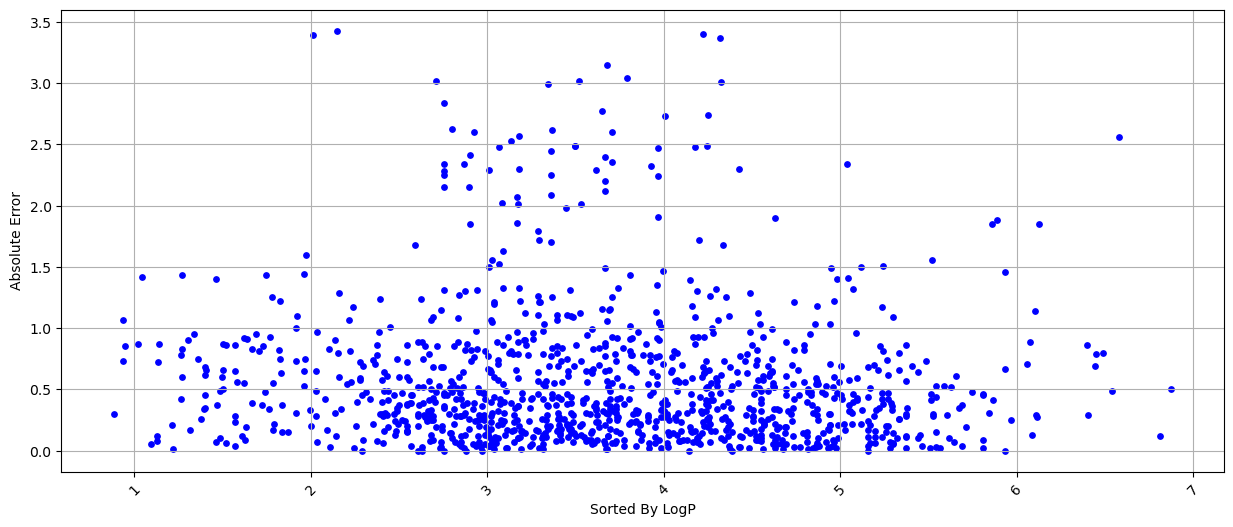

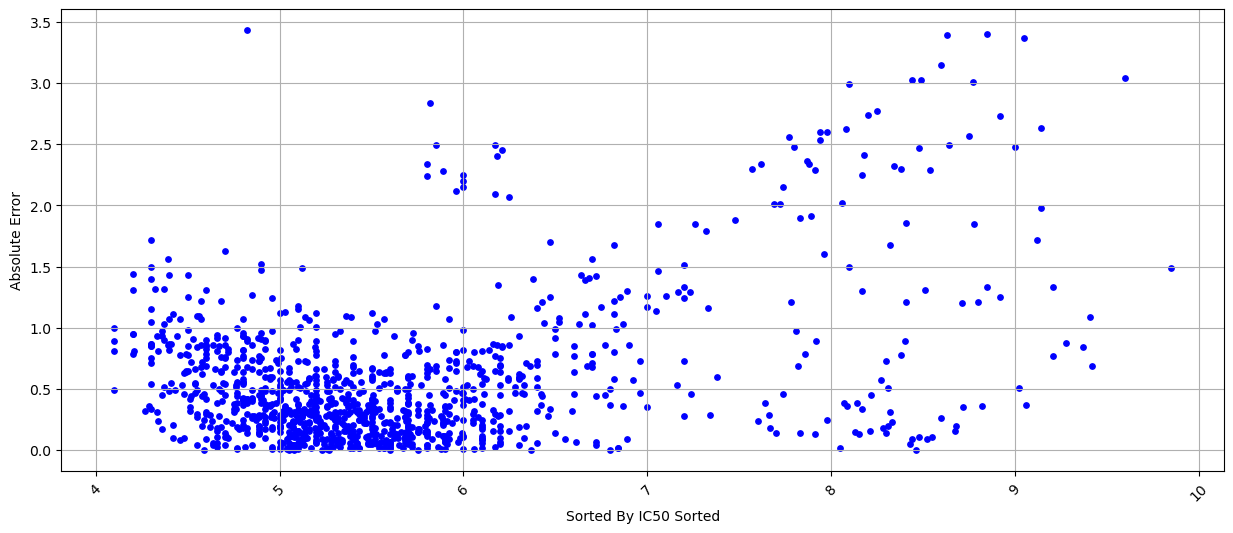

In [36]:
plot_graphs(df, results_df)

In [25]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
734,Cc1ccc2c(-c3nnc(SCCCN4CCc5ccc6oc(C(F)(F)C(F)(F...,6.60,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
717,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(F)(F)C(F)(F)...,7.00,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
217,CCc1nc2cc3c(c(Br)c2o1)CCN(CCCCSc1nnc(-c2cccc4n...,5.80,605.606,6.77792,0.142700,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
618,COc1ccccc1CC(c1ccccc1)N1CCNCC1,4.41,296.414,2.88420,0.917990,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1044,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2CCCCC2)c1,7.82,328.456,3.49240,0.920243,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)C1CCNC1,4.70,315.244,3.45350,0.922780,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1248,Oc1cccc(OC2CC3CCC(C2)N3Cc2ccccc2)c1,5.80,309.409,3.96660,0.927450,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [49]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.3530802482037583, pvalue=5.008685941942771e-05)
PearsonRResult(statistic=0.09914106249293529, pvalue=0.26938138455613464)
PearsonRResult(statistic=0.2248371891406799, pvalue=0.01136945964746039)
PearsonRResult(statistic=0.016318564478677383, pvalue=0.8560834932645183)
PearsonRResult(statistic=0.4216032593644296, pvalue=8.810518795632185e-07)
PearsonRResult(statistic=0.335381027108405, pvalue=0.00012357609700223984)
PearsonRResult(statistic=0.36273776235893557, pvalue=2.990041923053371e-05)
PearsonRResult(statistic=0.6852414966116794, pvalue=8.756985554362081e-19)
PearsonRResult(statistic=0.7975655043752965, pvalue=5.379355347932306e-29)


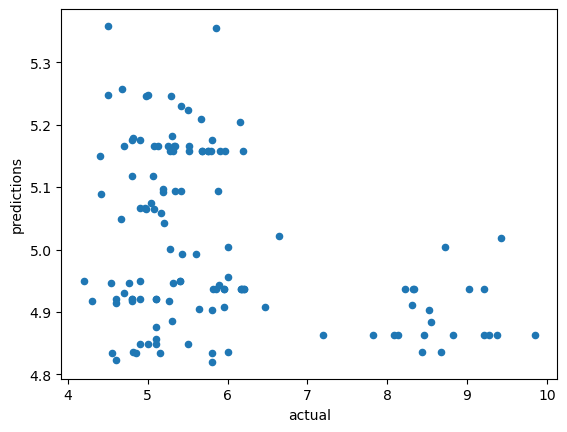

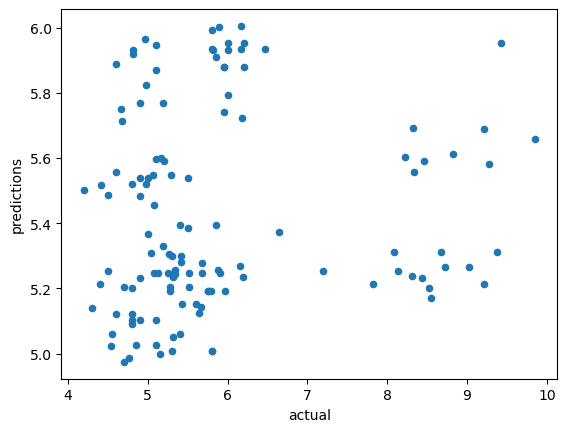

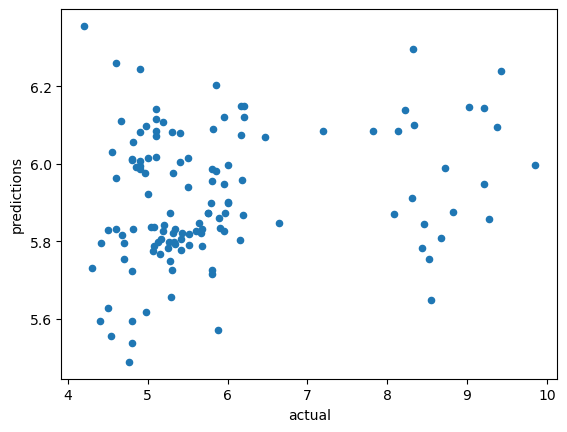

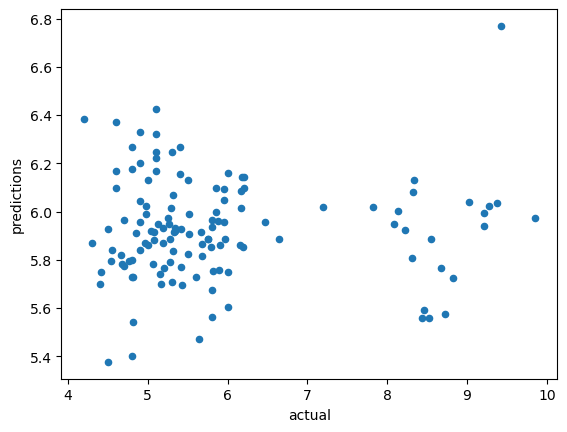

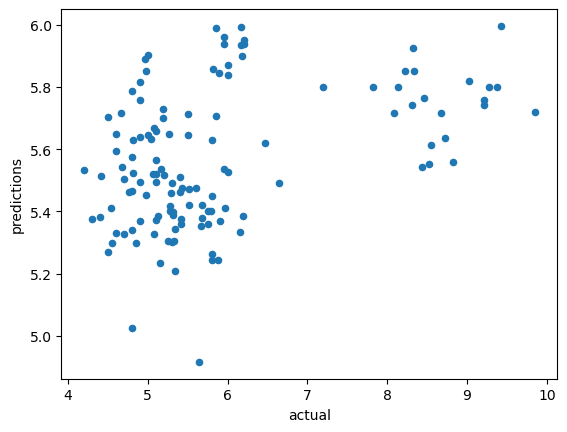

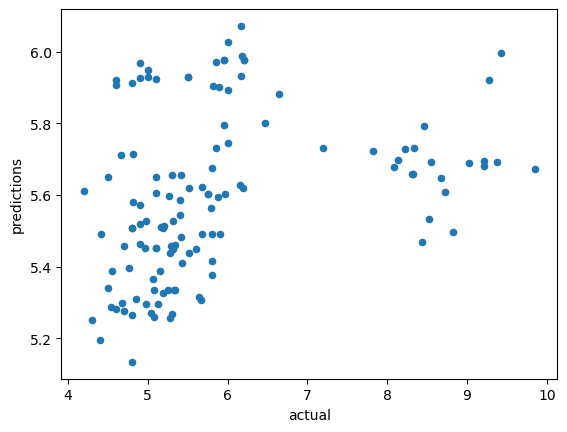

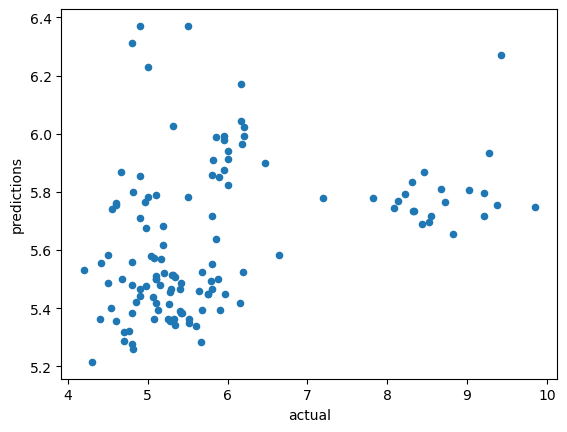

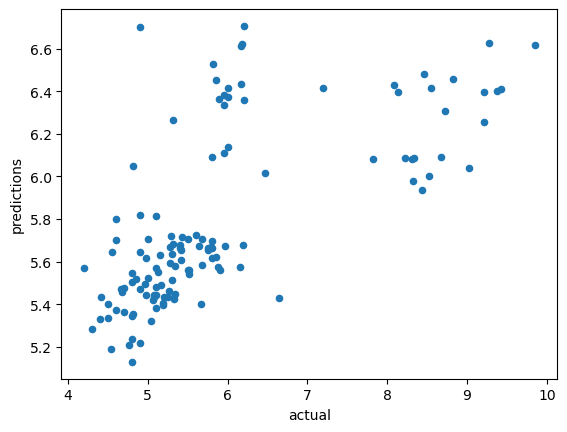

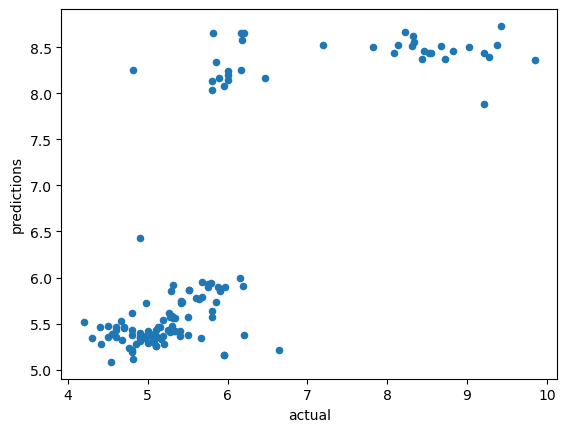

In [50]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [51]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(43, 3)
(14, 3)
(0, 3)
(0, 3)
(1, 3)
(2, 3)
(0, 3)
(2, 3)
(3, 3)


In [52]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(71, 3)
(15, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(0, 3)
(2, 3)


In [53]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(6, 3)
(62, 3)
(77, 3)
(77, 3)
(76, 3)
(77, 3)
(77, 3)
(77, 3)
(75, 3)


In [54]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(5, 3)
(34, 3)
(48, 3)
(48, 3)
(47, 3)
(46, 3)
(48, 3)
(46, 3)
(45, 3)


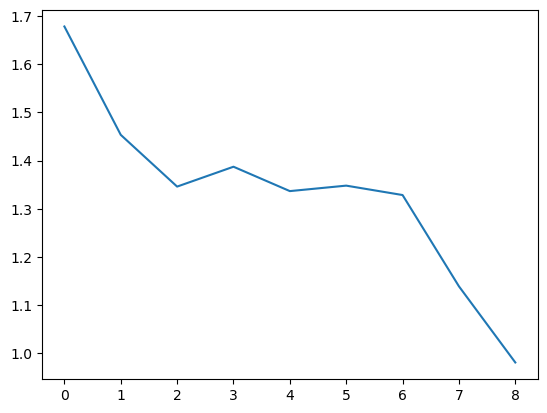

In [55]:
plt.plot(rmse)
plt.show()